In [ ]:
import os
import numpy as np
import pandas as pd
import sys
import json
import networkx as nx
import matplotlib.pyplot as plt
from venny4py.venny4py import *
import math
from glob import glob
from tslearn import barycenters

# Add rpy2
%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(ComplexHeatmap)
    library(cowplot)
    library(facefuns)
    library(factoextra)
    library(FactoMineR)
    library(ggh4x)
    library(ggraph)
    library(ggpubr)
    library(ggrain)
    library(ggridges)
    library(ggseg)
    library(ggsignif)
    library(ggVennDiagram)
    library(glue)
    library(igraph)
    library(LaCroixColoR)
    library(patchwork)
    library(RColorBrewer)
    library(rlist)
    library(scales)
    library(see)
    library(splitstackshape)
    library(tidyverse)
    library(VennDiagram) 
})


# Set cowplot theme
theme_set(theme_cowplot())

## How does each SPI perform in distinguishing (1) stimulus type and (2) relevance type, using averaged epochs compared across participants?

We can load the results from the logistic regression classification for (1) stimulus type and (2) relevance type):

In [3]:
# load pyspi SPI info
pyspi_SPI_info = pd.read_csv("../feature_extraction/pyspi_SPI_info.csv")

# Define path for derivatives directory
deriv_dir = "/Users/abry4213/data/Cogitate_MEG/derivatives"

# Initialize list for pyspi results
all_pyspi_res_averaged_epochs_list = []

# Load pyspi results -- update to where you have stored your pyspi results
pyspi_res_path_averaged = f"{deriv_dir}/time_series_features/averaged_epochs"

# Load classification res -- update to where you have stored your classification results
classification_res_path = f"{deriv_dir}/classification_results/across_participants"
averaged_stimulus_type_LR_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_stimulus_types_Logistic_Regression_classification_results.csv")
averaged_stimulus_type_SVM_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_stimulus_types_Linear_SVM_classification_results.csv")
averaged_relevance_type_LR_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_relevance_types_Logistic_Regression_classification_results.csv")

# Add meta_ROI_pair column that combines the 'from' and 'to' meta-ROIs
averaged_stimulus_type_LR_classification_res["meta_ROI_pair"] = averaged_stimulus_type_LR_classification_res.meta_ROI_from + "__" + averaged_stimulus_type_LR_classification_res.meta_ROI_to
averaged_relevance_type_LR_classification_res["meta_ROI_pair"] = averaged_relevance_type_LR_classification_res.meta_ROI_from + "__" + averaged_relevance_type_LR_classification_res.meta_ROI_to

# Load in pyspi results
# for pyspi_res_file in os.listdir(pyspi_res_path_averaged):
for pyspi_res_file in glob(f"{pyspi_res_path_averaged}/*.csv"):
    pyspi_res_averaged = pd.read_csv(pyspi_res_file)
    all_pyspi_res_averaged_epochs_list.append(pyspi_res_averaged)

# Concatenate pyspi results
all_pyspi_res_averaged_epochs = pd.concat(all_pyspi_res_averaged_epochs_list)

## What is the overall distribution in SPI performance per classification task?

Before diving into any specific result, let's first see the distribution in performance across all SPIs per stimulus task classification problem (e.g., 'Face' vs. 'Object') by meta-ROI pair (e.g., 'GNWT' to 'CS')

In [149]:
%%R -i averaged_stimulus_type_LR_classification_res -w 900 -h 650 

# Create raincloud plot visualization for all stimulus type classification results
for (relevance_type in unique(averaged_stimulus_type_LR_classification_res$relevance_type)) {
    averaged_stimulus_type_LR_classification_res %>% 
        # Filter accuracy to >50% for visualization purposes
        filter(accuracy > 0.5, relevance_type==relevance_type) %>%
        mutate(accuracy = 100*accuracy) %>%
        rowwise() %>%
        # Want a specific order for the meta-ROI pair in the plot
        mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("V1_V2__Category_Selective",
                                                        "Category_Selective__V1_V2",
                                                        "Category_Selective__IPS",
                                                        "IPS__Category_Selective",
                                                        "IPS__Prefrontal_Cortex",
                                                        "Prefrontal_Cortex__IPS",
                                                        "Prefrontal_Cortex__V1_V2",
                                                        "V1_V2__Prefrontal_Cortex",
                                                        "V1_V2__IPS",
                                                        "IPS__V1_V2",
                                                        "Prefrontal_Cortex__Category_Selective",
                                                        "Category_Selective__Prefrontal_Cortex")))  %>% 
        mutate(stimulus_combo = factor(stimulus_combo, levels = c("('face', 'letter')", "('face', 'object')",  
                                                                "('false', 'face')",  "('false', 'letter')",
                                                                "('letter', 'object')", "('false', 'object')"))) %>%
        filter(!is.na(stimulus_combo)) %>%
        ggplot(data=., mapping=aes(x=stimulus_presentation, y=accuracy, fill=meta_ROI_pair)) +
        # Create half violins colored by meta-ROI pair and stimulus presentation period
        geom_violinhalf(scale="width", color="black", position = position_dodge(width = 2), width=1)  +
        geom_point(aes(color = meta_ROI_pair), position = position_jitter(width = 0.075, height=0),
                                size = 1.75, alpha=0.6, stroke=0) +
        stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
                show.legend=FALSE, position = position_dodge(width=1.4)) +
        facet_grid(meta_ROI_pair ~ stimulus_combo, scales="free", switch="y") + 
        theme(legend.position = "bottom") +
        scale_x_discrete(expand = c(0, 0)) +
        xlab("Stimulus presentation period") +
        ylab("Cross-validated accuracy by SPI (%)") +
        labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
        theme(strip.background = element_blank(),
            strip.placement="outside",
            legend.position="none",
            panel.spacing = unit(0.5, "lines"),
            axis.text.x = element_text(angle=45, hjust=1)) +
        coord_flip()

    # ggsave(glue('../plots/inter_subject_classification/Stimulus_wise_classification_performance_by_meta_ROI_pair_{relevance_type}.svg'), width=10, height=12, units='in', dpi=300)
}


## How about simply face vs. non-face?

In [70]:
averaged_stimulus_type_LR_classification_res.head()

,SPI,meta_ROI_from,meta_ROI_to,relevance_type,stimulus_presentation,stimulus_combo,accuracy,balanced_accuracy,AUC,meta_ROI_pair
0,cov_EmpiricalCovariance,Category_Selective,IPS,Relevant-non-target,on,"('false', 'face')",0.602778,0.602778,0.654000,Category_Selective__IPS
1,cov_EmpiricalCovariance,Category_Selective,IPS,Relevant-non-target,on,"('false', 'letter')",0.500000,0.500000,0.500000,Category_Selective__IPS
2,cov_EmpiricalCovariance,Category_Selective,IPS,Relevant-non-target,on,"('false', 'object')",0.483333,0.483333,0.529321,Category_Selective__IPS
3,cov_EmpiricalCovariance,Category_Selective,IPS,Relevant-non-target,on,"('face', 'letter')",0.612222,0.612222,0.604716,Category_Selective__IPS
4,cov_EmpiricalCovariance,Category_Selective,IPS,Relevant-non-target,on,"('face', 'object')",0.595000,0.595000,0.580259,Category_Selective__IPS


`summarise()` has grouped output by 'SPI', 'meta_ROI_from', 'meta_ROI_to',
'meta_ROI_pair', 'relevance_type'. You can override using the `.groups`
argument.


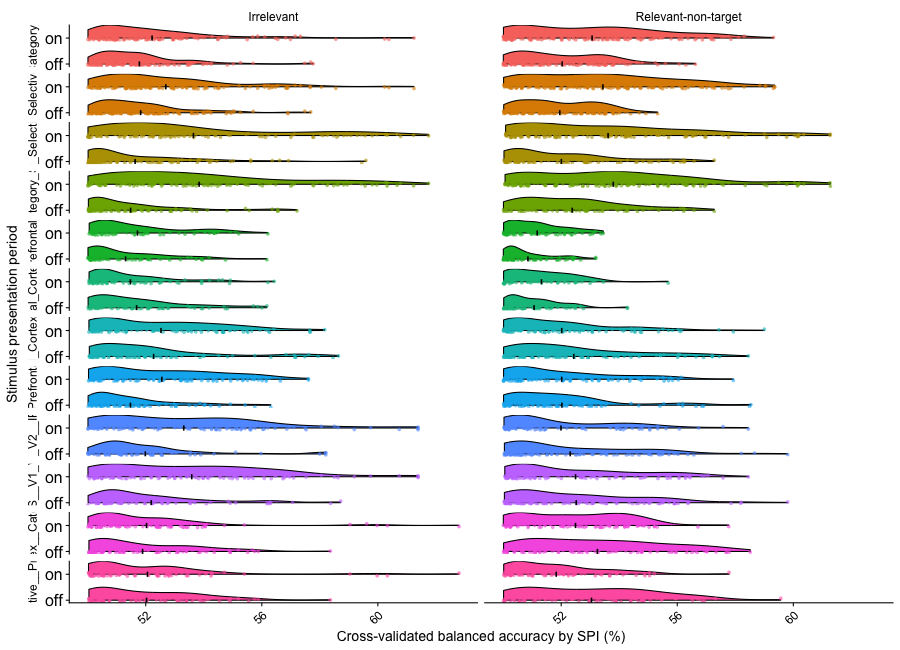

In [17]:
%%R -i averaged_stimulus_type_LR_classification_res -w 900 -h 650 

averaged_stimulus_type_LR_classification_res %>% 
    # Take the average across face vs non-face 
    filter(str_detect(stimulus_combo, "face")) %>%
    group_by(SPI, meta_ROI_from, meta_ROI_to, meta_ROI_pair, relevance_type, stimulus_presentation) %>%
    summarise(balanced_accuracy = mean(balanced_accuracy)) %>%
    # Filter balanced accuracy to >50% for visualization purposes
    filter(balanced_accuracy > 0.5) %>%
    mutate(balanced_accuracy = 100*balanced_accuracy) %>%
    rowwise() %>%
    # Want a specific order for the meta-ROI pair in the plot
    mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("V1_V2__Category_Selective",
                                                    "Category_Selective__V1_V2",
                                                    "Category_Selective__IPS",
                                                    "IPS__Category_Selective",
                                                    "IPS__Prefrontal_Cortex",
                                                    "Prefrontal_Cortex__IPS",
                                                    "Prefrontal_Cortex__V1_V2",
                                                    "V1_V2__Prefrontal_Cortex",
                                                    "V1_V2__IPS",
                                                    "IPS__V1_V2",
                                                    "Prefrontal_Cortex__Category_Selective",
                                                    "Category_Selective__Prefrontal_Cortex"))) %>%
    ggplot(data=., mapping=aes(x=stimulus_presentation, y=balanced_accuracy, fill=meta_ROI_pair)) +
    # Create half violins colored by meta-ROI pair and stimulus presentation period
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 2), width=1)  +
    geom_point(aes(color = meta_ROI_pair), position = position_jitter(width = 0.075, height=0),
                            size = 1.75, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
            show.legend=FALSE, position = position_dodge(width=1.4)) +
    facet_grid(meta_ROI_pair ~ relevance_type, scales="free_y", switch="y") + 
    theme(legend.position = "bottom") +
    scale_x_discrete(expand = c(0, 0)) +
    xlab("Stimulus presentation period") +
    ylab("Cross-validated balanced accuracy by SPI (%)") +
    labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
    theme(strip.background = element_blank(),
        strip.placement="outside",
        legend.position="none",
        panel.spacing = unit(0.5, "lines"),
        axis.text.y = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) +
    coord_flip()

# ggsave(glue('../plots/inter_subject_classification/Face_vs_non_face_classification_performance_by_meta_ROI_pair.svg'), width=5, height=12, units='in', dpi=300)

### Examine the top-performing SPI for each ROI pair, zooming in on the top 4

In [170]:
%%R -i averaged_stimulus_type_LR_classification_res -o top_res

# Line plot showing the maximum cross-validated accuracy for each 
# stimulus comparison (x-axis) and meta-ROI pair (colored lines)
top_res <- averaged_stimulus_type_LR_classification_res %>% 
    group_by(meta_ROI_pair, stimulus_combo) %>% 
    # Want a specific order for the meta-ROI pair in the plot
    mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("V1_V2__Category_Selective",
                                                    "Category_Selective__V1_V2",
                                                    "Category_Selective__IPS",
                                                    "IPS__Category_Selective",
                                                    "IPS__Prefrontal_Cortex",
                                                    "Prefrontal_Cortex__IPS",
                                                    "Prefrontal_Cortex__V1_V2",
                                                    "V1_V2__Prefrontal_Cortex",
                                                    "V1_V2__IPS",
                                                    "IPS__V1_V2",
                                                    "Prefrontal_Cortex__Category_Selective",
                                                    "Category_Selective__Prefrontal_Cortex")),
            stimulus_combo = str_replace_all(stimulus_combo, "False", "false"))  %>% 
    # Find maximum accuracy
    filter(accuracy==max(accuracy,na.rm=T)) %>%
    ungroup() %>%
    mutate(accuracy=100*accuracy,
           stimulus_combo = factor(stimulus_combo, 
                                   levels = c("('face', 'object')",  
                                              "('false', 'face')",
                                              "('face', 'letter')", 
                                              "('letter', 'object')", 
                                              "('false', 'object')", 
                                              "('false', 'letter')"))) %>% 
    filter(!is.na(stimulus_combo)) %>%
    group_by(meta_ROI_pair) %>%
    mutate(is_max = ifelse(accuracy==max(accuracy,na.rm=T), "Max", "Not Max"),
           max_label = ifelse(is_max=="Max", round(accuracy, 1), NA_real_)) 
                                              
top_res %>%
    ggplot(data=., mapping=aes(x=stimulus_combo, y=accuracy, color=meta_ROI_pair, group=meta_ROI_pair)) +
    geom_line(linewidth=1.25) +
    geom_point(aes(size=is_max)) + 
    scale_size_manual(values=c("Not Max" = 0, "Max" = 4)) +
    geom_text(aes(label=max_label), hjust=0.5, vjust=-1.25, size=4.5) +
    xlab("Stimulus comparison") +
    ylab("Cross-validated accuracy (%)") +
    # Set y-axis breaks to only 60 and 65
    scale_y_continuous(breaks=c(60,65)) +
    scale_x_discrete(expand = c(0.1, 0)) +
    facet_grid(meta_ROI_pair ~ ., scales="free_x") +
    theme(legend.position="none", strip.background = element_blank(),
          strip.placement="outside", strip.text = element_blank(),
          panel.spacing = unit(0.25, "lines"))
# ggsave('../plots/inter_subject_classification/Max_performance_for_each_stim_combo_by_meta_ROI_pair.svg', width=4.5, height=8, units='in', dpi=300)

In addition: Warning message:
Removed 64 rows containing missing values or values outside the scale range
(`geom_text()`). 


In [4]:
%%R -i averaged_stimulus_type_LR_classification_res -o top_eight_res

# Line plot showing the maximum cross-validated accuracy for each 
# stimulus comparison (x-axis) and meta-ROI pair (colored lines)
top_eight_res <- averaged_stimulus_type_LR_classification_res %>% 
    filter(stimulus_combo != "('face', 'non-face')") %>%
    group_by(meta_ROI_pair, stimulus_combo) %>% 
    filter(accuracy==max(accuracy,na.rm=T)) %>%
    ungroup() %>%
    mutate(accuracy=100*accuracy) %>% 
    arrange(desc(accuracy)) %>%
    slice_max(order_by=accuracy, n=8) %>% 
    dplyr::select(accuracy, meta_ROI_to, meta_ROI_from, SPI, stimulus_combo, stimulus_presentation, relevance_type) %>% 
    mutate(meta_ROI_pair = paste(meta_ROI_from, meta_ROI_to, sep="__"))

In [5]:
pyspi_res_top_SPIs = all_pyspi_res_averaged_epochs.merge(top_eight_res, how='inner')

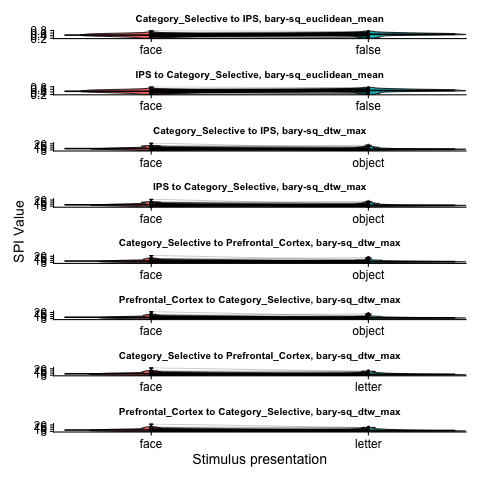

In [9]:
%%R -i top_eight_res,pyspi_res_top_SPIs

plot_list = list()
for (i in 1:nrow(top_eight_res)) {
    this_SPI = top_eight_res$SPI[i]
    this_meta_ROI_from = top_eight_res$meta_ROI_from[i]
    this_meta_ROI_to = top_eight_res$meta_ROI_to[i]
    stimulus_combo = top_eight_res$stimulus_combo[i]

    # Extract first and second stimulus from stimulus_combo
    stimulus_1 = strsplit(stimulus_combo, ",")[[1]][1] %>% str_replace_all(., "\\(|\\)|'| ", "")
    stimulus_2 = strsplit(stimulus_combo, ",")[[1]][2] %>% str_replace_all(., "\\(|\\)|'| ", "")

    # Filter pyspi results for the current meta-ROI pair and stimulus combo
    pyspi_res_top_SPIs_subset = pyspi_res_top_SPIs %>%
        mutate(stimulus_type = ifelse(stimulus_type=="False", "false", stimulus_type)) %>%
        filter(meta_ROI_from == this_meta_ROI_from,
               meta_ROI_to == this_meta_ROI_to,
               SPI == this_SPI,
               stimulus_type %in% c(stimulus_1, stimulus_2))

    p <- pyspi_res_top_SPIs_subset %>% 
        mutate(meta_ROI_pair = glue("{meta_ROI_from}__{meta_ROI_to}")) %>%
        ungroup() %>%
        mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("V1_V2__Category_Selective",
                                                    "Category_Selective__V1_V2",
                                                    "Category_Selective__IPS",
                                                    "IPS__Category_Selective",
                                                    "IPS__Prefrontal_Cortex",
                                                    "Prefrontal_Cortex__IPS",
                                                    "Prefrontal_Cortex__V1_V2",
                                                    "V1_V2__Prefrontal_Cortex",
                                                    "V1_V2__IPS",
                                                    "IPS__V1_V2",
                                                    "Prefrontal_Cortex__Category_Selective",
                                                    "Category_Selective__Prefrontal_Cortex"))) %>% 
        ggplot(data=., mapping=aes(x=stimulus_type, y=value)) +
        geom_violin(aes(fill=stimulus_type)) + 
        geom_point(aes(group=subject_ID), alpha=0.6, size=0.85) +
        stat_summary(color="black", fun="mean", geom="crossbar", width=0.8, linewidth=0.3, show.legend=FALSE) +
        geom_line(aes(group=subject_ID), alpha=0.2, linewidth=0.5) +
        xlab("Stimulus presentation") +
        ylab("SPI Value") +
        ggtitle(glue("{this_meta_ROI_from} to {this_meta_ROI_to}, {this_SPI}")) +
        # facet_grid(meta_ROI_pair ~ ., scales="free", switch="both") +
        scale_x_discrete(expand=c(0,0)) +
        theme(strip.placement="outside", 
                strip.background=element_blank(),
                legend.position="none")

    plot_list[[i]] <- p
}

wrap_plots(plot_list, ncol=1) +
  plot_layout(axis_titles = "collect") &
  theme(plot.title = element_text(hjust = 0.5, size=10))
# ggsave("../plots/inter_subject_classification/Top_eight_SPIs_by_meta_ROI_pair_and_stimulus_combo.svg", width=4, height=18, units='in', dpi=300)

## Barycenter visualization

### Visualizing the squared barycenter with Euclidean distance [mean] SPI

In [6]:
barysq_euc_mean = pyspi_res_top_SPIs.query("SPI=='bary-sq_euclidean_mean' & meta_ROI_from == 'Category_Selective' & meta_ROI_to == 'IPS' & stimulus_type in ['face', 'False']")

# Find the difference in SPI values between face and false stimuli, grouping by subject_ID
barysq_euc_mean_diff = barysq_euc_mean.pivot(index="subject_ID", columns="stimulus_type", values="value").reset_index()
barysq_euc_mean_diff["face_vs_false"] = abs(barysq_euc_mean_diff["face"] - barysq_euc_mean_diff["False"])
 # Find row with maximum face_vs_false value
max_face_vs_false = barysq_euc_mean_diff.loc[barysq_euc_mean_diff["face_vs_false"].idxmax()]
max_face_vs_false

stimulus_type
subject_ID          CB038
False            0.591228
face             0.277236
face_vs_false    0.313992
Name: 68, dtype: object

In [46]:
# Extract the time series for this subject
sub_CB038_time_series = pd.read_csv(f"{deriv_dir}/MEG_time_series/sub-CB038_ses-1_meg_1000ms_all_time_series.csv")
sub_CB038_time_series_of_interest = sub_CB038_time_series.query("relevance_type == 'Irrelevant' & stimulus_type in ['face', 'False'] & times >= 0.0 & times < 1")

# Compute the CS <--> IPS barycenter with Euclidean distance

# False stimuli
sub_CB038_CS_false = sub_CB038_time_series_of_interest.query("stimulus_type == 'False'").Category_Selective.values
sub_CB038_IPS_false = sub_CB038_time_series_of_interest.query("stimulus_type == 'False'").IPS.values
# z-score the time series
sub_CB038_CS_false = (sub_CB038_CS_false - sub_CB038_CS_false.mean()) / sub_CB038_CS_false.std()
sub_CB038_IPS_false = (sub_CB038_IPS_false - sub_CB038_IPS_false.mean()) / sub_CB038_IPS_false.std()
sub_CB038_false_barycenter = barycenters.euclidean_barycenter([sub_CB038_CS_false, sub_CB038_IPS_false])

# Face stimuli
sub_CB038_CS_face = sub_CB038_time_series_of_interest.query("stimulus_type == 'face'").Category_Selective.values
sub_CB038_IPS_face = sub_CB038_time_series_of_interest.query("stimulus_type == 'face'").IPS.values
# z-score the time series
sub_CB038_CS_face = (sub_CB038_CS_face - sub_CB038_CS_face.mean()) / sub_CB038_CS_face.std()
sub_CB038_IPS_face = (sub_CB038_IPS_face - sub_CB038_IPS_face.mean()) / sub_CB038_IPS_face.std()
sub_CB038_face_barycenter = barycenters.euclidean_barycenter([sub_CB038_CS_face, sub_CB038_IPS_face])

# Flatten the barycenter arrays from (1000,1) to (1000,)
sub_CB038_false_barycenter = sub_CB038_false_barycenter.flatten()
sub_CB038_face_barycenter = sub_CB038_face_barycenter.flatten()

# Square the barycenter arrays
sub_CB038_false_barycenter_sq = np.square(sub_CB038_false_barycenter)
sub_CB038_face_barycenter_sq = np.square(sub_CB038_face_barycenter)

# Print the mean squared barycenter for face vs false
print("Mean squared barycenter for face stimuli: ", np.mean(sub_CB038_face_barycenter_sq))
print("Mean squared barycenter for false stimuli: ", np.mean(sub_CB038_false_barycenter_sq))

Mean squared barycenter for face stimuli:  0.2970573114719432
Mean squared barycenter for false stimuli:  0.5944635036343306


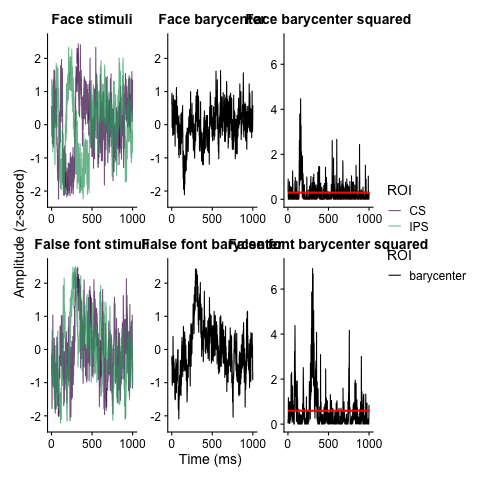

In [63]:
%%R -i sub_CB038_false_barycenter,sub_CB038_face_barycenter,sub_CB038_false_barycenter_sq,sub_CB038_face_barycenter_sq,sub_CB038_CS_face,sub_CB038_IPS_face,sub_CB038_CS_false,sub_CB038_IPS_false

# Plot time series vs barycenter for face
face_barycenter_ts_p <- data.frame(times=1:length(sub_CB038_face_barycenter_sq), IPS = sub_CB038_IPS_face,
           CS = sub_CB038_CS_face) %>%
    pivot_longer(cols=c("IPS", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line(alpha=0.7) +
    ggtitle("Face stimuli") 

# Plot barycenter only for face
face_barycenter_p <- data.frame(times=1:length(sub_CB038_face_barycenter), 
                                value = sub_CB038_face_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line() +
    ggtitle("Face barycenter")

# Plot barycenter squared only for face
face_barycenter_sq_p <- data.frame(times=1:length(sub_CB038_face_barycenter_sq), 
                                value = sub_CB038_face_barycenter_sq,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    geom_line() +
    stat_smooth(method="lm", formula=y~1, se=FALSE, color="red") +
    scale_y_continuous(limits=c(0,7)) +
    ggtitle("Face barycenter squared")

# Plot time series vs barycenter for false
false_barycenter_ts_p <- data.frame(times=1:length(sub_CB038_false_barycenter_sq), 
IPS = sub_CB038_IPS_false,
           CS = sub_CB038_CS_false) %>%
    pivot_longer(cols=c("IPS", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line(alpha=0.7) +
    ggtitle("False font stimuli")

# Plot barycenter only for false
false_barycenter_p <- data.frame(times=1:length(sub_CB038_false_barycenter),
                                value = sub_CB038_false_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black",
                                "IPS" = "#2ea16b",
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line() +
    ggtitle("False font barycenter")

# Plot barycenter squared only for false
false_barycenter_sq_p <- data.frame(times=1:length(sub_CB038_false_barycenter_sq), 
                                value = sub_CB038_false_barycenter_sq,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    geom_line() +
    stat_smooth(method="lm", formula=y~1, se=FALSE, color="red")+
    scale_y_continuous(limits=c(0,7)) +
    ggtitle("False font barycenter squared")

# Time series plus barycenter
wrap_plots(list(face_barycenter_ts_p, face_barycenter_p, face_barycenter_sq_p,
       false_barycenter_ts_p, false_barycenter_p, false_barycenter_sq_p), ncol=3) +
       plot_layout(axis_titles = "collect", guides = "collect") &
       theme(plot.title = element_text(hjust = 0.5, size=14)) &
       xlab("Time (ms)") &
       ylab("Amplitude (z-scored)") &
       scale_x_continuous(breaks=c(0, 500, 1000))

# ggsave("../plots/inter_subject_classification/Time_series_vs_barycenter_for_face_and_false_font_CB038.svg", width=7, height=4, units='in', dpi=300)

### Visualize an example for max of squared barycenter with soft-DTW geometry between the CS and IPS regions

In [49]:
barysq_softdtw_max = pyspi_res_top_SPIs.query("SPI=='bary-sq_dtw_max' & meta_ROI_from == 'Category_Selective' & meta_ROI_to == 'IPS' & stimulus_type in ['face', 'object']")

# Find the difference in SPI values between face and false stimuli, grouping by subject_ID
barysq_softdtw_max_diff = barysq_softdtw_max.pivot(index="subject_ID", columns="stimulus_type", values="value").reset_index()
barysq_softdtw_max_diff["face_vs_object"] = abs(barysq_softdtw_max_diff["face"] - barysq_softdtw_max_diff["object"])
 # Find row with maximum face_vs_object value
max_face_vs_object = barysq_softdtw_max_diff.loc[barysq_softdtw_max_diff["face_vs_object"].idxmax()]
max_face_vs_object

stimulus_type
subject_ID            CB035
face              22.078399
object             8.514842
face_vs_object    13.563557
Name: 66, dtype: object

In [54]:
# Extract the time series for this subject
sub_CB035_time_series = pd.read_csv(f"{deriv_dir}/MEG_time_series/sub-CB035_ses-1_meg_1000ms_all_time_series.csv")
sub_CB035_time_series_of_interest = sub_CB035_time_series.query("relevance_type == 'Irrelevant' & stimulus_type in ['face', 'object'] & times >= 0.0 & times < 1")

# Compute the CS <--> IPS barycenter with expectation maximisation (dtw)

# object stimuli stimuli
sub_CB035_CS_object = sub_CB035_time_series_of_interest.query("stimulus_type == 'object'").Category_Selective.values
sub_CB035_IPS_object = sub_CB035_time_series_of_interest.query("stimulus_type == 'object'").IPS.values
# z-score the time series
sub_CB035_CS_object = (sub_CB035_CS_object - sub_CB035_CS_object.mean()) / sub_CB035_CS_object.std()
sub_CB035_IPS_object = (sub_CB035_IPS_object - sub_CB035_IPS_object.mean()) / sub_CB035_IPS_object.std()
sub_CB035_object_barycenter = barycenters.dtw_barycenter_averaging([sub_CB035_CS_object, sub_CB035_IPS_object])

# Face stimuli
sub_CB035_CS_face = sub_CB035_time_series_of_interest.query("stimulus_type == 'face'").Category_Selective.values
sub_CB035_IPS_face = sub_CB035_time_series_of_interest.query("stimulus_type == 'face'").IPS.values
# z-score the time series
sub_CB035_CS_face = (sub_CB035_CS_face - sub_CB035_CS_face.mean()) / sub_CB035_CS_face.std()
sub_CB035_IPS_face = (sub_CB035_IPS_face - sub_CB035_IPS_face.mean()) / sub_CB035_IPS_face.std()
sub_CB035_face_barycenter = barycenters.dtw_barycenter_averaging([sub_CB035_CS_face, sub_CB035_IPS_face])

# Flatten the barycenter arrays from (1000,1) to (1000,)
sub_CB035_object_barycenter = sub_CB035_object_barycenter.flatten()
sub_CB035_face_barycenter = sub_CB035_face_barycenter.flatten()

# Square the barycenter arrays
sub_CB035_object_barycenter_sq = np.square(sub_CB035_object_barycenter)
sub_CB035_face_barycenter_sq = np.square(sub_CB035_face_barycenter)

# Print the mean squared barycenter for face vs object
print("Max squared barycenter for face stimuli: ", np.max(sub_CB035_face_barycenter_sq))
print("Max squared barycenter for object stimuli: ", np.max(sub_CB035_object_barycenter_sq))

Max squared barycenter for face stimuli:  23.11921748189525
Max squared barycenter for object stimuli:  9.502434435062794


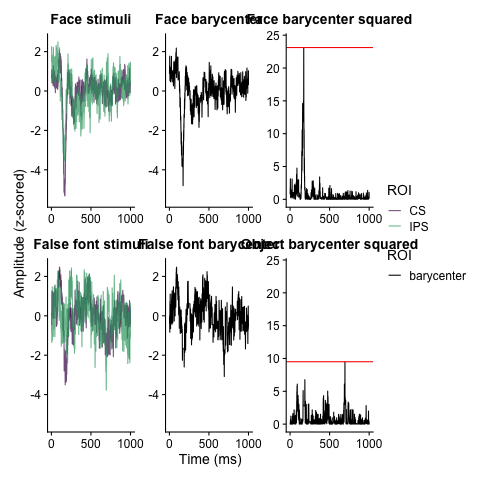

In [65]:
%%R -i sub_CB035_object_barycenter,sub_CB035_face_barycenter,sub_CB035_object_barycenter_sq,sub_CB035_face_barycenter_sq,sub_CB035_CS_face,sub_CB035_IPS_face,sub_CB035_CS_object,sub_CB035_IPS_object

# Plot time series vs barycenter for face
face_barycenter_ts_p <- data.frame(times=1:length(sub_CB035_face_barycenter_sq), IPS = sub_CB035_IPS_face,
           CS = sub_CB035_CS_face) %>%
    pivot_longer(cols=c("IPS", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-5.5, 2.5)) +
    geom_line(alpha=0.7) +
    ggtitle("Face stimuli") 

# Plot barycenter only for face
face_barycenter_p <- data.frame(times=1:length(sub_CB035_face_barycenter), 
                                value = sub_CB035_face_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-5.5, 2.5)) +
    geom_line() +
    ggtitle("Face barycenter")

# Plot barycenter squared only for face
face_barycenter_sq_p <- data.frame(times=1:length(sub_CB035_face_barycenter_sq), 
                                value = sub_CB035_face_barycenter_sq,
                                ROI = "barycenter") %>%
    mutate(max_value = max(value)) %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    geom_line() +
    # Add a horizontal line corresponding to the maximum value of the barycenter squared
    geom_hline(aes(yintercept=max_value), color="red") +
    scale_y_continuous(limits=c(0,24)) +
    ggtitle("Face barycenter squared")

# Plot time series vs barycenter for object
object_barycenter_ts_p <- data.frame(times=1:length(sub_CB035_object_barycenter_sq), 
IPS = sub_CB035_IPS_object,
           CS = sub_CB035_CS_object) %>%
    pivot_longer(cols=c("IPS", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-5.5, 2.5)) +
    geom_line(alpha=0.7) +
    ggtitle("False font stimuli")

# Plot barycenter only for object
object_barycenter_p <- data.frame(times=1:length(sub_CB035_object_barycenter),
                                value = sub_CB035_object_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black",
                                "IPS" = "#2ea16b",
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-5.5, 2.5)) +
    geom_line() +
    ggtitle("False font barycenter")

# Plot barycenter squared only for object
object_barycenter_sq_p <- data.frame(times=1:length(sub_CB035_object_barycenter_sq), 
                                value = sub_CB035_object_barycenter_sq,
                                ROI = "barycenter") %>%
    mutate(max_value = max(value)) %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    geom_line() +
    # Add a horizontal line corresponding to the maximum value of the barycenter squared
    geom_hline(aes(yintercept=max_value), color="red") +
    scale_y_continuous(limits=c(0,24)) +
    ggtitle("Object barycenter squared")

# Time series plus barycenter
wrap_plots(list(face_barycenter_ts_p, face_barycenter_p, face_barycenter_sq_p,
       object_barycenter_ts_p, object_barycenter_p, object_barycenter_sq_p), ncol=3) +
       plot_layout(axis_titles = "collect", guides = "collect") &
       theme(plot.title = element_text(hjust = 0.5, size=14)) &
       xlab("Time (ms)") &
       ylab("Amplitude (z-scored)") &
       scale_x_continuous(breaks=c(0, 500, 1000))

# ggsave("../plots/inter_subject_classification/Time_series_vs_barycenter_for_face_and_object_CB035.svg", width=7, height=4, units='in', dpi=300)

## Euler diagrams for SPIs greater than 62% accuracy

In [36]:
# Filter to accuracy > 60%
face_non_face = "('face', 'non-face')"
averaged_stimulus_type_LR_classification_res_above_62 = averaged_stimulus_type_LR_classification_res.query('accuracy >= 0.62 & stimulus_combo != @face_non_face')

# For each ROI (from or to, doesn't matter), find all of the unique SPIs that have accuracy > 60%
unique_SPIs_from = averaged_stimulus_type_LR_classification_res_above_62.groupby("meta_ROI_from").SPI.unique().reset_index()
unique_SPIs_to = averaged_stimulus_type_LR_classification_res_above_62.groupby("meta_ROI_to").SPI.unique().reset_index()

# Convert from list-column to long format
unique_SPIs_from_long = unique_SPIs_from.explode("SPI")
unique_SPIs_to_long = unique_SPIs_to.explode("SPI")

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


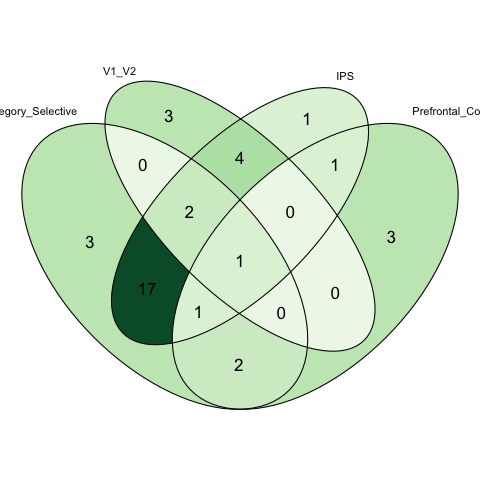

In [37]:
%%R -i unique_SPIs_from_long

SPIs_from_venn <- split(unique_SPIs_from_long, unique_SPIs_from_long$meta_ROI_from)
SPIs_from_venn <- lapply(SPIs_from_venn, function(x) x %>% pull(SPI))
SPIs_from_venn <- SPIs_from_venn[c("Category_Selective", "V1_V2", "IPS", "Prefrontal_Cortex")]

venn_from <- Venn(SPIs_from_venn)
data_from <- process_data(venn_from, shape_id = "401f")

ggplot() +
  # 1. region count layer
  geom_polygon(aes(X, Y, fill = count, group = id), 
          data = venn_regionedge(data_from)) +
  # 2. set edge layer
  geom_path(aes(X, Y, group = id), 
          data = venn_setedge(data_from), 
          show.legend = FALSE) +
  # 3. set label layer
  geom_text(aes(X, Y, label = name), 
               data = venn_setlabel(data_from)) +
  # 4. region label layer
  geom_text(aes(X, Y, label = count), size=6,
                data = venn_regionlabel(data_from)) +
  coord_equal() +
  theme_void() +
  scale_fill_distiller(palette = "Greens", direction = 1) +
  theme(legend.position="none")
  
# ggsave("../plots/inter_subject_classification/Top_SPIs_from_Euler.svg", width=4.5, height=4.5, units='in', dpi=300)

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


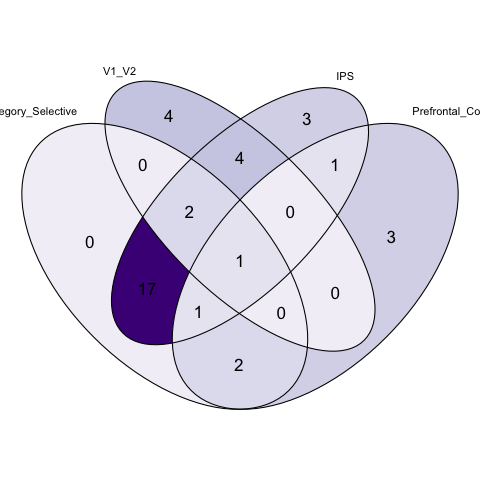

In [38]:
%%R -i unique_SPIs_to_long

SPIs_to_venn <- split(unique_SPIs_to_long, unique_SPIs_to_long$meta_ROI_to)
SPIs_to_venn <- lapply(SPIs_to_venn, function(x) x %>% pull(SPI))
SPIs_to_venn <- SPIs_to_venn[c("Category_Selective", "V1_V2", "IPS", "Prefrontal_Cortex")]

venn_to <- Venn(SPIs_to_venn)
data_to <- process_data(venn_to, shape_id = "401f")

ggplot() +
  # 1. region count layer
  geom_polygon(aes(X, Y, fill = count, group = id), 
          data = venn_regionedge(data_to)) +
  # 2. set edge layer
  geom_path(aes(X, Y, group = id), 
          data = venn_setedge(data_to), 
          show.legend = FALSE) +
  # 3. set label layer
  geom_text(aes(X, Y, label = name), 
               data = venn_setlabel(data_to)) +
  # 4. region label layer
  geom_text(aes(X, Y, label = count), size=6, 
                data = venn_regionlabel(data_to)) +
  coord_equal() +
  theme_void() +
  scale_fill_distiller(palette = "Purples", direction = 1) +
  labs(fill="# SPIs") +
  theme(legend.position="none")

# ggsave("../plots/inter_subject_classification/Top_SPIs_to_Euler.svg", width=4.5, height=4.5, units='in', dpi=300)

### Which SPI is at the center of both Euler diagrams?

In [69]:
%%R -i unique_SPIs_from_long,unique_SPIs_to_long

SPI_all_four_from <- unique_SPIs_from_long %>% 
    group_by(SPI) %>% 
    count() %>% 
    ungroup() %>% 
    filter(n == 4)

SPI_all_four_to <- unique_SPIs_to_long %>%
    group_by(SPI) %>% 
    count() %>% 
    ungroup() %>% 
    filter(n == 4)

print(glue("SPIs that are present in all four ROIs (from): {SPI_all_four_from$SPI}"))
print(glue("SPIs that are present in all four ROIs (to): {SPI_all_four_to$SPI}"))

SPIs that are present in all four ROIs (from): bary-sq_softdtw_max
SPIs that are present in all four ROIs (to): bary-sq_softdtw_max


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


## What type(s) of SPIs perform the best (1) by meta-ROI pair and (2) by stimulus type comparison?

Since each SPI belongs to a particular literature category (e.g., 'spectral' or 'information theory'), we can compare the composition of the top-performing (>62% accuracy) SPIs in each context -- first, by meta-ROI pair:

In [39]:
# Merge SPI info with results
unique_SPIs_from_long = unique_SPIs_from_long.merge(pyspi_SPI_info, how='left', on='SPI')
unique_SPIs_to_long = unique_SPIs_to_long.merge(pyspi_SPI_info, how='left', on='SPI')

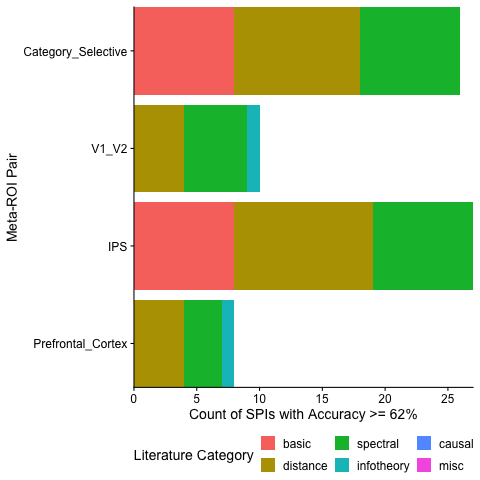

In [41]:
%%R -i unique_SPIs_from_long 

# A) By meta-ROI pair, stacked bar chart showing the relative composition of SPIs with accuracy > 65%
unique_SPIs_from_long %>% 
    mutate(Literature_category = factor(Literature_category, levels = c("basic", "distance", "spectral", 
                                                                        "infotheory", "causal", "misc")),
            meta_ROI_from = factor(meta_ROI_from, levels = rev(c("Category_Selective", "V1_V2", "IPS", "Prefrontal_Cortex")))) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_from, fill=Literature_category)) +
    # Reverse the order in which the bars are stacked
    geom_bar(show.legend = TRUE, position = position_stack(reverse = TRUE)) +
    coord_flip() +
    xlab("Meta-ROI Pair") +
    scale_fill_discrete(drop=FALSE) +
    # Keep all factor levels in legend
    guides(fill=guide_legend(title="Literature Category")) +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0)) +
    ylab("Count of SPIs with Accuracy >= 62%") +
    theme(legend.position = "bottom")
# ggsave('../plots/inter_subject_classification/ROI_from_top_SPI_categories.svg', width=5, height=3.5, units='in', dpi=300)

Joining with `by = join_by(SPI)`


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


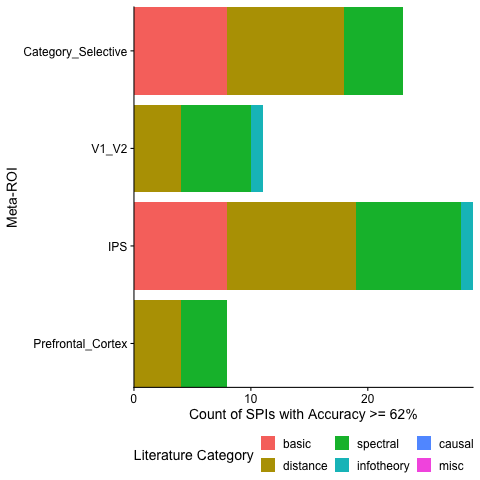

In [70]:
%%R -i unique_SPIs_to_long,pyspi_SPI_info 

# A) By meta-ROI pair, stacked bar chart showing the relative composition of SPIs with accuracy > 65%
unique_SPIs_to_long %>% 
    left_join(., pyspi_SPI_info %>% mutate(Literature_category = factor(Literature_category,
                                                                        levels = c("basic", "distance", "spectral", 
                                                                        "infotheory", "causal", "misc")))) %>% 
        mutate(meta_ROI_to = factor(meta_ROI_to, 
        levels = rev(c("Category_Selective", "V1_V2", "IPS", "Prefrontal_Cortex")))) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_to, fill=Literature_category)) +
    # Reverse the order in which the bars are stacked
    geom_bar(show.legend = TRUE, position = position_stack(reverse = TRUE)) +
    coord_flip() +
    xlab("Meta-ROI") +
    scale_fill_discrete(drop=FALSE) +
    # Keep all factor levels in legend
    guides(fill=guide_legend(title="Literature Category")) +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0)) +
    ylab("Count of SPIs with Accuracy >= 62%") +
    theme(legend.position = "bottom")
# ggsave('../plots/inter_subject_classification/ROI_to_top_SPI_categories.svg', width=5, height=3.5, units='in', dpi=300)

## What is the max performance by SPI across all analyses?

In [76]:
%%R -i averaged_stimulus_type_LR_classification_res,pyspi_SPI_info

averaged_stimulus_type_LR_classification_res %>% 
    group_by(SPI) %>% 
    filter(accuracy==max(accuracy, na.rm=T)) %>%
    ungroup() %>% 
    distinct(SPI, accuracy) %>% 
    filter(accuracy > 0.5) %>% 
    left_join(., pyspi_SPI_info) %>% 
    mutate(SPI = fct_reorder(SPI, accuracy, .desc=F),
           Literature_category = factor(Literature_category, 
                                        levels = c("basic", "distance", "spectral", 
                                        "infotheory", "causal", "misc")),
           SPI_label = ifelse(SPI=="bary-sq_softdtw_max", "*", NA_character_)) %>%
    ggplot(data=., mapping=aes(x=SPI, y=100*accuracy)) +
    geom_point(aes(color=Literature_category), alpha=0.8, stroke=0) +
    # Add a line from the point to the x-axis
    geom_segment(aes(xend=SPI, yend=50, color=Literature_category)) +
    geom_line() +
    geom_text(aes(label=SPI_label), size=4) +
    ylab("Maximum Accuracy (%)") +
    coord_flip() +
    scale_y_continuous(expand=c(0,0)) +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="none")
# ggsave('../plots/inter_subject_classification/Max_classification_performance_by_SPI_category.svg', width=3, height=8, units='in', dpi=300)

Joining with `by = join_by(SPI)`
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


In addition: Warning message:
Removed 244 rows containing missing values or values outside the scale range
(`geom_text()`). 


# Task relevance analysis

In [ ]:
%%R -i relevance_type_classification_res -w 900 -h 650 

# Create raincloud plot visualization for all stimulus type classification results
relevance_type_classification_res %>% 
    # Filter accuracy to >50% for visualization purposes
    filter(accuracy > 0.5) %>%
    mutate(accuracy = 100*accuracy, 
           stimulus_presentation = factor(stimulus_presentation, levels = c("on", "off"))) %>%
    rowwise() %>%
    mutate(sp_and_roi = paste0(meta_ROI_pair, "__", stimulus_presentation)) %>%
    mutate(sp_and_roi = factor(sp_and_roi, levels = rev(c("IIT_Category_Selective__on",
                                                        "IIT_Category_Selective__off",
                                                        "Category_Selective_IIT__on",
                                                        "Category_Selective_IIT__off",
                                                        "Category_Selective_GNWT__on",
                                                        "Category_Selective_GNWT__off",
                                                        "GNWT_Category_Selective__on",
                                                        "GNWT_Category_Selective__off")))) %>%
    ggplot(data=., mapping=aes(x=sp_and_roi, y=accuracy, fill=sp_and_roi)) +
    # Create half violins colored by meta-ROI pair and stimulus presentation period
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=1)  +
    geom_point(aes(color = sp_and_roi), position = position_jitter(width = 0.075, height=0),
                            size = 1.5, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
            show.legend=FALSE, position = position_dodge(width=1.4)) +
    # Custom color lookup table for (1) meta-ROI pair and (2) stimulus presentation period
    scale_color_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    scale_fill_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    theme(legend.position = "bottom") +
    scale_x_discrete(expand = c(0, 0))+
    xlab("Meta-ROI Pair") +
    ylab("Cross-validated accuracy by SPI (%)") +
    labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
    theme(strip.background = element_blank(),
          legend.position="none",
          axis.text.x = element_text(angle=45, hjust=1)) +
    coord_flip()

# ggsave('plots/Relevance_type_classification_performance_by_meta_ROI_pair.svg', width=4.5, height=6, units='in', dpi=300)

In [5]:
averaged_relevance_type_LR_classification_res.head()

,SPI,meta_ROI_from,meta_ROI_to,stimulus_presentation,comparison,accuracy,meta_ROI_pair
0,cov_EmpiricalCovariance,Category_Selective,IPS,on,Relevant non-target vs. Irrelevant,0.533750,Category_Selective__IPS
1,cov_GraphicalLasso,Category_Selective,IPS,on,Relevant non-target vs. Irrelevant,0.533611,Category_Selective__IPS
2,cov_GraphicalLassoCV,Category_Selective,IPS,on,Relevant non-target vs. Irrelevant,0.521528,Category_Selective__IPS
3,cov_LedoitWolf,Category_Selective,IPS,on,Relevant non-target vs. Irrelevant,0.536389,Category_Selective__IPS
4,cov_OAS,Category_Selective,IPS,on,Relevant non-target vs. Irrelevant,0.537778,Category_Selective__IPS


In [16]:
%%R -i averaged_relevance_type_LR_classification_res -w 900 -h 650 

averaged_relevance_type_LR_classification_res %>% 
    group_by(SPI, meta_ROI_from, meta_ROI_to, meta_ROI_pair, stimulus_presentation) %>%
    summarise(accuracy = mean(accuracy)) %>%
    # Filter accuracy to >50% for visualization purposes
    filter(accuracy > 0.5) %>%
    mutate(accuracy = 100*accuracy) %>%
    rowwise() %>%
    # Want a specific order for the meta-ROI pair in the plot
    mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("V1_V2__Category_Selective",
                                                    "Category_Selective__V1_V2",
                                                    "Category_Selective__IPS",
                                                    "IPS__Category_Selective",
                                                    "IPS__Prefrontal_Cortex",
                                                    "Prefrontal_Cortex__IPS",
                                                    "Prefrontal_Cortex__V1_V2",
                                                    "V1_V2__Prefrontal_Cortex",
                                                    "V1_V2__IPS",
                                                    "IPS__V1_V2",
                                                    "Prefrontal_Cortex__Category_Selective",
                                                    "Category_Selective__Prefrontal_Cortex"))) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_pair, y=accuracy, fill=meta_ROI_pair)) +
    # Create half violins colored by meta-ROI pair and stimulus presentation period
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 2), width=1)  +
    geom_point(aes(color = meta_ROI_pair), position = position_jitter(width = 0.075, height=0),
                            size = 1.75, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
            show.legend=FALSE, position = position_dodge(width=1.4)) +
    facet_grid(meta_ROI_pair ~ stimulus_presentation, scales="free_y", switch="y") + 
    theme(legend.position = "bottom") +
    scale_x_discrete(expand = c(0, 0)) +
    ylab("Cross-validated accuracy by SPI (%)") +
    labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
    theme(strip.background = element_blank(),
        strip.placement="outside",
        legend.position="none",
        panel.spacing = unit(0.5, "lines"),
        strip.text.y = element_blank(),
        strip.text.x = element_text(size=14, face="bold"),
        axis.text = element_text(size=14)) +
    coord_flip()

# ggsave(glue('../plots/inter_subject_classification/Relevance_type_classification_performance_by_meta_ROI_pair.svg'), width=8, height=8, units='in', dpi=300)

`summarise()` has grouped output by 'SPI', 'meta_ROI_from', 'meta_ROI_to',
'meta_ROI_pair'. You can override using the `.groups` argument.
